In [1]:
import sys
import os

# Asegurar que la carpeta actual está en el path de Python
sys.path.append(os.getcwd())

In [2]:
%%writefile consts.py

# para todo el proyecto (no cambian)
SRATE = 48000 # frecuencia de muestreo
CHUNK = 1024  # tamaño de los CHUNKs

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]

Writing consts.py


In [8]:
%%writefile osc.py

from consts import *
import numpy as np         
# import sounddevice as sd       
# import matplotlib.pyplot as plt

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out

Overwriting osc.py


In [11]:
%%writefile oscFM.py

import numpy as np   
import sounddevice as sd
import tkinter as tk
import osc
# import matplotlib.pyplot as plt
from consts import *

class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0
        # moduladora = βsin(2πfm)
        self.mod = osc.Osc(freq=fm,amp=beta)
        
    def set_fm(self, new_fm):
        self.fm = new_fm
        self.mod = osc.Osc(freq=self.fm,amp=self.beta)

    def get_fm(self):
        return self.fm

    def set_beta(self, new_beta):
        self.beta = new_beta
        self.mod = osc.Osc(freq=self.fm, amp=self.beta)

    def get_beta(self):
        return self.beta



    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = self.mod.next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 

Overwriting oscFM.py


In [13]:
#%% una envolvente sencilla
import numpy as np 
class Env:
      def __init__(self, attack=0.1, release=0.9, amp=0.8):
        self.env = np.concatenate((
            np.linspace(0, amp, int(attack * SRATE)),
            np.linspace(amp, 0, int(release * SRATE))
        ))
        self.frame = 0

    def next(self):
        if self.frame >= len(self.env):
            return None
        else:
            out = self.env[self.frame:self.frame+CHUNK]
            out = np.pad(out,(0,CHUNK-len(out)),'constant')
            self.frame += CHUNK
            return out

In [14]:
env = Env(attack=0.01, release=0.15, amp=0.2)


varios = np.zeros(0)
for i in range(12):
    varios = np.append(varios,env.next())

plt.plot(varios)

NameError: name 'SRATE' is not defined

In [41]:
class Note:
    def __init__(self,freq=440.0,attack=0.1,release=0.9,amp=0.8):
        self.osc = Osc(freq)
        self.env = Env(attack,release,amp)

    def next(self):
        env = self.env.next()
        if env is None:
            return None
        return self.osc.next()*env

In [42]:
# stream de salida con callBack
input = None
def callback(outdata, frames, time, status):
    if status: print(status)
    if input:    
        s = input.next()
        s = np.float32(s)
    else:
        s = np.zeros(CHUNK,dtype=np.float32)
    outdata[:] = s.reshape(-1, 1)

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()


In [ ]:
# inicialización de la ventanas 
root=Tk()
# Caja de texto
text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"Press 'm/M' to modify FM, and 'b/B' to modify Beta\n")

# Inicialización de oscilador FM
fm_osc = OscFM(fc=220, fm=100, beta=0.5)

# call back para la pulsación de teclas
def key_down(event):
    global input, fm_osc  # conexión con sounddevice y oscilador FM
    if event.char == 'b':
        fm_osc.set_beta(fm_osc.get_beta() * 0.9)
        print(f'Beta decreased: {fm_osc.get_beta()}')
    elif event.char == 'B':
        fm_osc.set_beta(fm_osc.get_beta() * 1.1)
        print(f'Beta increased: {fm_osc.get_beta()}')
    elif event.char == 'm':
        fm_osc.set_fm(fm_osc.get_fm() * 0.9)
        print(f'FM frequency decreased: {fm_osc.get_fm()}')
    elif event.char == 'M':
        fm_osc.set_fm(fm_osc.get_fm() * 1.1)
        print(f'FM frequency increased: {fm_osc.get_fm()}')

# enlace de la pulsación de teclas con la función key_down
text.bind('<Key>', key_down)


# arrancamos todo!!
root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()

beta  index
beta  index
beta  index


In [36]:
import importlib
import osc
import oscFM

# Recargar módulos en caso de haberlos modificado
importlib.reload(oscFM)
importlib.reload(osc)

<module 'osc' from 'd:\\AA-VIC\\MUS\\practicas\\practica2\\osc.py'>

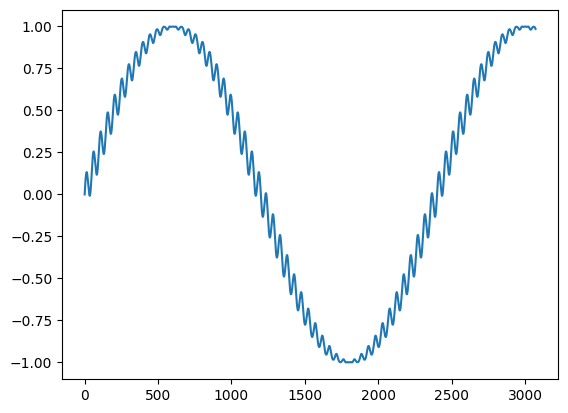

In [37]:
from oscFM import *

# oscilador FM    
o = OscFM(fc=20,fm=1000,beta=0.1)

# concatenamos 3 chunks y dibujamos
sgn = np.zeros(0)
for i in range(3):
    sgn = np.concatenate((sgn,o.next()))
plt.plot(sgn)

In [38]:
# también podemos hacerlo sonar
from oscFM import *
import sounddevice as sd
# oscilador FM    
o = OscFM(amp=0.2,fc=220,fm=1000,beta=0.1)

# concatenamos 30 chunks y hacemos sonar 
# 
sgn = np.zeros(0)
for i in range(100): # 100*CHUNK = 102400; 102400/SRATE = 2.13 segundos
    sgn = np.concatenate((sgn,o.next()))

sd.play(sgn)